In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patheffects as pe
import matplotlib.gridspec as gridspec

In [2]:
include_clusters = ['A', 'B', 'C', 'D', 'E', 'F']
relabels = {'A': 'I', 'B': 'II', 'C': 'III', 'D': 'IV', 'E': 'V', 'F': 'VI', 'W': 'W', 'X': 'X'}
include_clusters = [relabels[cl] for cl in include_clusters]
feature_cols = ['el_edap_scaled', 'el_edep_scaled', 'height_scaled', 'w_edep', 'valley_confinement', 'min_rhp', 'vol']
rename_dict = {
    'el_edap_scaled': 'EDZ Access Stage',
    'el_edep_scaled': 'EDZ Exit Stage',
    'height_scaled': 'EDZ Stage Range',
    'w_edep': 'EDZ Width',
    'valley_confinement': 'EDZ Relative Width',
    'vol': 'Diagnostic Size',
    'min_rhp': 'Max Lateral Expansion',
    'slope': 'Slope',
    'DASqKm': 'Drainage Area',
    'regression_valley_confinement': 'Valley Confinement',
    'streamorder': 'Stream Order',
    'celerity_detrended': 'Shape Celerity (m^(2/3))',
    'celerity': 'Celerity (m/s)'
}
cpal = ["#8f00cc", "#cc0000", "#cc7000", "#cdbc00", "#07cc00", "#00cccc", '#2b54d8', '#979797']
significant_groups = {
    'EDZ Access Stage': {'A': 'i', 'B': 'ii', 'C': 'iii', 'D': 'iii', 'E': 'iv', 'F': 'iv'},
    'EDZ Exit Stage': {'A': 'i', 'B': 'ii', 'C': 'iii', 'D': 'iv', 'E': 'v', 'F': 'vi'},
    'EDZ Stage Range': {'A': 'i', 'B': 'ii', 'C': 'iii', 'D': 'ii', 'E': 'iii', 'F': 'i'},
    'EDZ Width': {'A': 'i', 'B': 'i', 'C': 'ii', 'D': 'ii', 'E': 'iii', 'F': 'ii'},
    'Diagnostic Size': {'A': 'i', 'B': 'ii', 'C': 'ii', 'D': 'iii', 'E': 'iv', 'F': 'iv'},
    'EDZ Relative Width': {'A': 'i', 'B': 'ii', 'C': 'iii', 'D': 'ii', 'E': 'iv', 'F': 'i'},
    'Max Lateral Expansion': {'A': 'i', 'B': 'ii', 'C': 'ii', 'D': 'iii', 'E': 'iv', 'F': 'iii'},
    'Drainage Area': {'A': 'i', 'B': 'ii', 'C': 'iii', 'D': 'iv', 'E': 'iii', 'F': 'iv', 'W': 'i', 'X': 'i'},
    'Valley Confinement': {'A': 'i', 'B': 'ii', 'C': 'ii, iii, iv', 'D': 'iii', 'E': 'v', 'F': 'i, iv', 'W': 'iv', 'X': 'vi'},
    'Stream Order': {'A': 'i', 'B': 'ii', 'C': 'iii', 'D': 'iv, v', 'E': 'iii, iv', 'F': 'v', 'W': 'vi', 'X': 'vi'},
    'Slope': {'A': 'i', 'B': 'ii', 'C': 'i', 'D': 'iii', 'E': 'iii', 'F': 'iv', 'W': 'v', 'X': 'i, ii'},
}
for k in significant_groups.keys():
    vals = significant_groups[k]
    vals = {relabels[k2]: vals[k2] for k2 in vals.keys()}
    significant_groups[k] = vals

# run_path = r"/netfiles/ciroh/floodplainsData/runs/8/run_metadata.json"
run_path = r"/netfiles/ciroh/floodplainsData/runs/9/run_metadata.json"
with open(run_path, 'r') as f:
    run_dict = json.loads(f.read())
in_path = os.path.join(run_dict['analysis_directory'], 'clustering', 'all_data.csv')
df = pd.read_csv(in_path)
df = df.rename(columns=rename_dict)
feature_cols = [rename_dict[col] for col in feature_cols]
df = df[df['cluster'].isin(include_clusters)]
ord = sorted(df['cluster'].unique())

In [3]:
# significance testing
from scipy.stats import ranksums

significant_groups = dict()
for c in feature_cols:   
    significant = np.zeros((len(ord), len(ord)))
    combos = np.meshgrid(ord, ord)

    for i in range(len(ord)):
        for j in range(len(ord)):
            x = df[df['cluster'] == combos[0][i, j]][c]
            x = x[~np.isnan(x)]
            y = df[df['cluster'] == combos[1][i, j]][c]
            y = y[~np.isnan(y)]
            if len(x) == 0 or len(y) == 0:
                continue
            w, p = ranksums(x, y)
            if p < 0.05:
                significant[i, j] = 1


    label_counter = 0
    groups = {c: set() for c in ord}
    for r in range(significant.shape[0]):
        tmp = significant[r, r:]  # above diagonal
        test = np.all(tmp == significant[:r, r:], axis=1)  # check if matches any preceeding rows
        if np.all(~test):  # if distinct, make new group
            label = chr(97 + label_counter)
            label_counter += 1
            for ind in range(r, significant.shape[0]):
                if significant[r, ind] == 0:
                    groups[ord[ind]].add(label)

    groups = {k: ','.join(sorted(v)) for k, v in groups.items()}
    significant_groups[c] = groups
    print(groups)

{'I': 'a', 'II': 'b', 'III': 'c', 'IV': 'c', 'V': 'd', 'VI': 'd'}
{'I': 'a', 'II': 'b', 'III': 'c', 'IV': 'd', 'V': 'e', 'VI': 'f'}
{'I': 'a', 'II': 'b', 'III': 'c', 'IV': 'd', 'V': 'c', 'VI': 'a'}
{'I': 'a', 'II': 'b', 'III': 'c', 'IV': 'd', 'V': 'e', 'VI': 'd'}
{'I': 'a', 'II': 'b', 'III': 'c', 'IV': 'b', 'V': 'd', 'VI': 'a'}
{'I': 'a', 'II': 'b', 'III': 'c', 'IV': 'd', 'V': 'e', 'VI': 'd'}
{'I': 'a', 'II': 'b', 'III': 'c', 'IV': 'd', 'V': 'e', 'VI': 'e'}


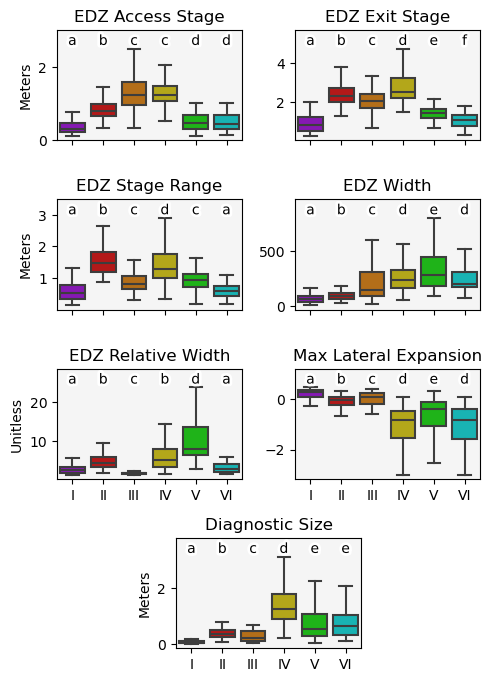

In [4]:
size = 5
aspect = (9 / 6.5)
w = size
h = size * aspect

cols = 2
rows = 4

fig, ax = plt.subplots(figsize=(w, h), sharey=False, sharex=True)
ax.remove()
spec = gridspec.GridSpec(ncols=2*cols, nrows=rows, figure=fig)
axs = np.empty((rows, cols), dtype=object)
for i in range(rows-1):
    for j in range(cols):
        tmp_ax = fig.add_subplot(spec[i, 2*j:(2*j)+2])
        axs[i, j] = tmp_ax
tmp_ax = fig.add_subplot(spec[3, 1:3])
axs[3, 0] = tmp_ax

ax_list = [ax for ax in axs.flat if ax is not None]
for i, ax in enumerate(ax_list):
    c = feature_cols[i]
    sns.boxplot(x='cluster', y=c, data=df, ax=ax, palette=cpal, order=ord, showfliers=False)
    ax.set(xlabel=None, ylabel=None, title=c, facecolor='#f5f5f5')
    if i not in [4, 5, 6]:
        ax.set_xticklabels([])

    # add significance groups
    labels = significant_groups[c]
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 0.15 * (ax.get_ylim()[1] - ax.get_ylim()[0]))
    
    y = ax.get_ylim()[1]  - (0.035 * (ax.get_ylim()[1] - ax.get_ylim()[0]))

    for ind, clus in enumerate(labels):
        x = ind
        ax.text(x, y, labels[clus], ha='center', va='top', fontsize=10, zorder=100, path_effects=[pe.withStroke(linewidth=4, foreground="white")])


axs[0, 0].set_ylabel('Meters', fontsize=10)
axs[1, 0].set_ylabel('Meters', fontsize=10)
axs[2, 0].set_ylabel('Unitless', fontsize=10)
axs[3, 0].set_ylabel('Meters', fontsize=10)

fig.tight_layout()


In [5]:
out_path = os.path.join(run_dict['analysis_directory'], 'clustering', 'final', 'Figure_5.png')
fig.savefig(out_path, dpi=400)

out_path = os.path.join(run_dict['analysis_directory'], 'clustering', 'final', 'Figure_5.pdf')
fig.savefig(out_path, dpi=400)